In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from spacy.lang.en import English

In [2]:
complaints = pd.read_csv('complaints.csv')

In [3]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353432 entries, 0 to 353431
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  353432 non-null  object
 1   Issue                         353432 non-null  object
dtypes: object(2)
memory usage: 5.4+ MB


In [4]:
complaints[['Consumer complaint narrative', 'Issue']] = complaints[['Consumer complaint narrative', 'Issue']].astype('str')

In [5]:
complaints.groupby('Issue').count().sort_values('Consumer complaint narrative', ascending = False)

,Consumer complaint narrative
Issue,
Incorrect information on your report,229305
Attempts to collect debt not owed,73163
Communication tactics,21243
Struggling to pay mortgage,17374
Fraud or scam,12347


In [6]:
# Define a regular expression pattern to match capitalized words
pattern = r'\b[A-Z][a-z]*\b'

# Define a function to count the number of capitalized words in a string
def count_capitalized_words(string):
    return len(re.findall(pattern, string))

# Apply the function to the 'strings' column
complaints['num_capitalized_words'] = complaints['Consumer complaint narrative'].apply(count_capitalized_words)

# Output the result
print(complaints['num_capitalized_words'])

0          14
1          36
2           5
3          96
4           5
         ... 
353427      2
353428     83
353429     73
353430    125
353431      1
Name: num_capitalized_words, Length: 353432, dtype: int64


In [7]:
Capital_Counts_by_Issue = pd.DataFrame(complaints.groupby('Issue')['num_capitalized_words'].sum())

In [8]:
complaints.head()

,Consumer complaint narrative,Issue,num_capitalized_words
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report,14
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam,36
2,I have a particular account that is stating th...,Incorrect information on your report,5
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed,96
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report,5


In [9]:
nlp = English()

count = 0

for complaint in complaints['Consumer complaint narrative']:
    doc = nlp(complaint)
    for token in doc:
        if token.is_alpha and token.is_title:
            count += 1

print(count)

6208654


In [10]:
counts_by_issue = {}

for issue in complaints['Issue'].unique():
    issue_df = complaints[complaints['Issue'] == issue]
    count = 0
    for complaint in issue_df['Consumer complaint narrative']:
        doc = nlp(complaint)
        for token in doc:
            if token.is_alpha and token.is_title:
                count += 1
    counts_by_issue[issue] = count

print(counts_by_issue)

{'Incorrect information on your report': 3770465, 'Fraud or scam': 295333, 'Attempts to collect debt not owed': 1289670, 'Communication tactics': 280825, 'Struggling to pay mortgage': 572361}


In [11]:
counts_by_issue

{'Incorrect information on your report': 3770465,
 'Fraud or scam': 295333,
 'Attempts to collect debt not owed': 1289670,
 'Communication tactics': 280825,
 'Struggling to pay mortgage': 572361}

In [27]:
cols = ['Consumer complaint narrative', 'Issue']
complaints = complaints[cols]

In [12]:
complaints['category_id'] = complaints['Issue'].factorize()[0]
category_id_complaints = complaints[['Issue', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_complaints.values)
id_to_category = dict(category_id_complaints[['category_id', 'Issue']].values)
complaints.head()

,Consumer complaint narrative,Issue,num_capitalized_words,category_id
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report,14,0
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam,36,1
2,I have a particular account that is stating th...,Incorrect information on your report,5,0
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed,96,2
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report,5,0


In [19]:
complaints['Consumer complaint narrative'].unique()

array(['My name is XXXX XXXX this complaint is not made in error neither is it being made by a third party. I declare under penalty of perjury I am alleging that a person or company- without my authorization- from unauthorized use of my social security number and card used my personal identifying information to apply for goods, services, or money ; and, was successful in creating some accounts. I have no knowledge of this and all is being investigated by the FTC and Under 15 U.S. Code 1681b Permissible purposes of consumer reports I never gave any written consent to report anything on my consumer reports. XXXX XXXX XXXX  XXXX XXXX Date Opened : XX/XX/2018 Balance : {$98000.00}. Please delete this account ASAP.',
       "I searched on XXXX for XXXXXXXX XXXX  and was pointed to a website I legitimately believed was XXXX. The website was XXXX whereas the authentic website is XXXX I proceeded to buy a gun from the fraudulent website and sent my money via XXXX as the spam seller requested, 

In [18]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353432 entries, 0 to 353431
Data columns (total 4 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  353432 non-null  object
 1   Issue                         353432 non-null  object
 2   num_capitalized_words         353432 non-null  int64 
 3   category_id                   353432 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 10.8+ MB


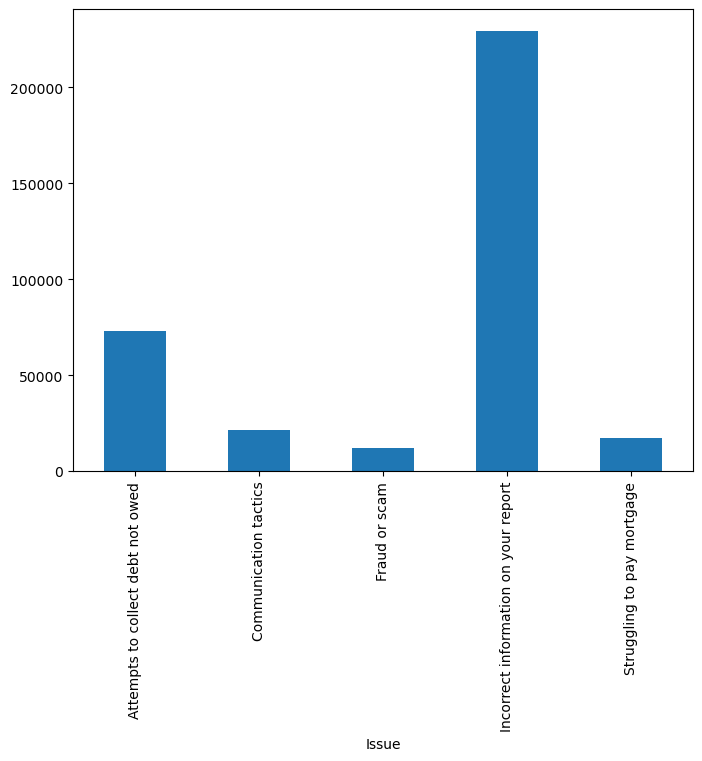

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
complaints.groupby('Issue')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1500, ngram_range=(2,2), stop_words='english')
features = tfidf.fit_transform(complaints['Consumer complaint narrative']).toarray()
labels = complaints.category_id
features.shape

(353432, 1568)

In [42]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Issue, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Issue))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Attempts to collect debt not owed':
  . Most correlated bigrams:
. collection agency
. collect debt
# 'Communication tactics':
  . Most correlated bigrams:
. stop calling
. times day
# 'Fraud or scam':
  . Most correlated bigrams:
. send money
. sent money
# 'Incorrect information on your report':
  . Most correlated bigrams:
. times day
. collect debt
# 'Struggling to pay mortgage':
  . Most correlated bigrams:
. short sale
. loan modification


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(complaints['Consumer complaint narrative'], complaints['Issue'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [20]:
print(clf.predict(count_vect.transform([

    'My name is XXXX XXXX this complaint is not made in error neither is it being made by a third party. I declare under penalty of perjury I am alleging that a person or company- without my authorization- from unauthorized use of my social security number and card used my personal identifying information to apply for goods, services, or money ; and, was successful in creating some accounts. I have no knowledge of this and all is being investigated by the FTC and Under 15 U.S. Code 1681b Permissible purposes of consumer reports I never gave any written consent to report anything on my consumer reports. XXXX XXXX XXXX  XXXX XXXX Date Opened : XX/XX/2018 Balance : {$98000.00}. Please delete this account ASAP.'

])))

['Incorrect information on your report']


In [21]:
complaints[complaints['Consumer complaint narrative'] == 'My name is XXXX XXXX this complaint is not made in error neither is it being made by a third party. I declare under penalty of perjury I am alleging that a person or company- without my authorization- from unauthorized use of my social security number and card used my personal identifying information to apply for goods, services, or money ; and, was successful in creating some accounts. I have no knowledge of this and all is being investigated by the FTC and Under 15 U.S. Code 1681b Permissible purposes of consumer reports I never gave any written consent to report anything on my consumer reports. XXXX XXXX XXXX  XXXX XXXX Date Opened : XX/XX/2018 Balance : {$98000.00}. Please delete this account ASAP.']

,Consumer complaint narrative,Issue,num_capitalized_words,category_id
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report,14,0


C:\Users\Pupnsuds90\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pupnsuds90\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

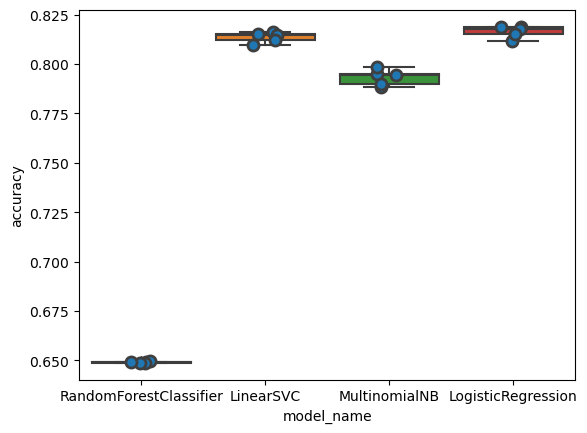

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.813670
LogisticRegression        0.816412
MultinomialNB             0.793392
RandomForestClassifier    0.649050
Name: accuracy, dtype: float64

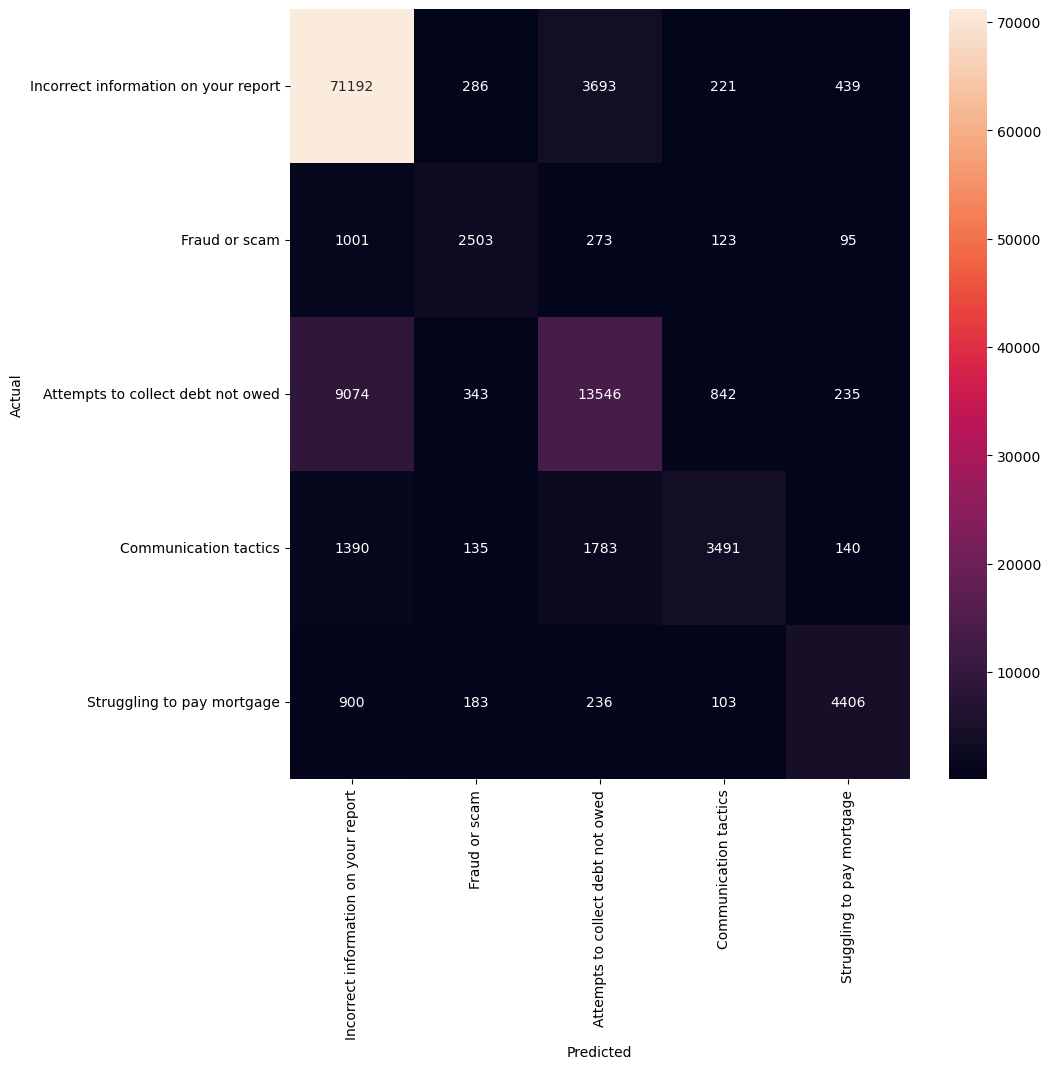

In [27]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, complaints.index, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_complaints.Issue.values, yticklabels=category_id_complaints.Issue.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
from IPython.display import display
for predicted in category_id_complaints.category_id:
  for actual in category_id_complaints.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(complaints.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Issue', 'Consumer complaint narrative']])
      print('')

'Fraud or scam' predicted as 'Incorrect information on your report' : 1001 examples.


,Issue,Consumer complaint narrative
69969,Fraud or scam,I have purchased from a scammer for one of the...
81034,Fraud or scam,This complaint is related to two complaints pr...
114216,Fraud or scam,I was sent {$25000.00} by a company that I ass...
209372,Fraud or scam,"Hi there, I was at the XXXX XXXX XXXX and was ..."
336148,Fraud or scam,Coinbase pro closed my account and will not gi...
...,...,...
200503,Fraud or scam,Yesterday XX/XX/2022 I was scammed {$350.00}. ...
130934,Fraud or scam,In the month of XX/XX/2019 I experience approx...
192926,Fraud or scam,I reached out to my bank on several occasions ...
176300,Fraud or scam,the name of the company id like to complain ab...



'Attempts to collect debt not owed' predicted as 'Incorrect information on your report' : 9074 examples.


,Issue,Consumer complaint narrative
269866,Attempts to collect debt not owed,On XX/XX/2018 I filled a written dispute with ...
112354,Attempts to collect debt not owed,15 U.S. Code 1681s2 - Responsibilities of furn...
322927,Attempts to collect debt not owed,XXXX called me a few months back stating that ...
137332,Attempts to collect debt not owed,Received notification of a negative mark on my...
213688,Attempts to collect debt not owed,This company is reporting inacurate informatio...
...,...,...
116464,Attempts to collect debt not owed,Was a victim of Hurricane Harvey and had to mo...
104548,Attempts to collect debt not owed,Ive sent letters to all 3 credit bureau asking...
118923,Attempts to collect debt not owed,I had an XXXX done XX/XX/2017 at a contracted ...
309937,Attempts to collect debt not owed,Debt Collection complain : To whom it may conc...



'Communication tactics' predicted as 'Incorrect information on your report' : 1390 examples.


,Issue,Consumer complaint narrative
322173,Communication tactics,I have sent Toyota Motor Credit Corp. an invoi...
253601,Communication tactics,Mountain run solutions has called and texted m...
290282,Communication tactics,This company keeps calling before XXXX
267799,Communication tactics,I do not have anything on my credit reports wi...
318915,Communication tactics,"Calling too frequently, being rude and obscene..."
...,...,...
211758,Communication tactics,Threatened to place a derogatory credit remark...
57302,Communication tactics,I have spent years dealing with Navient/XXXX X...
49455,Communication tactics,Its was closed off of my credit report and I u...
290999,Communication tactics,The company Northstar. I don't have any debts....



'Struggling to pay mortgage' predicted as 'Incorrect information on your report' : 900 examples.


,Issue,Consumer complaint narrative
6137,Struggling to pay mortgage,1. My credit bureaus account shows I am not a ...
58654,Struggling to pay mortgage,After a period of rapidly demising remuneratio...
345187,Struggling to pay mortgage,As a federal government employee in the midst ...
213640,Struggling to pay mortgage,Section 51.002 of the Texas Property Code had ...
264993,Struggling to pay mortgage,"I filed a complaint number XXXX, and US Bank r..."
...,...,...
276935,Struggling to pay mortgage,My house is on foreclosure and I wanted to get...
46924,Struggling to pay mortgage,Property Address : XXXX XXXX XXXX XXXX XXXX XX...
173835,Struggling to pay mortgage,I have been notified that PHH Mortgage Service...
298901,Struggling to pay mortgage,JP MORGAN CHASE Falsified documents sent forec...



'Incorrect information on your report' predicted as 'Fraud or scam' : 286 examples.


,Issue,Consumer complaint narrative
68860,Incorrect information on your report,On XX/XX/XXXX an order was placed using my syn...
295294,Incorrect information on your report,IM REACHING OUT And regards A IMPORTANT MATTER...
163070,Incorrect information on your report,Dates : XX/XX/2019 Amount : {$180.00} Action T...
175423,Incorrect information on your report,I finally logged into my XXXX yesterday XX/XX...
23564,Incorrect information on your report,Early Warning Services XXXX XXXX XXXX XXXX XXX...
...,...,...
169810,Incorrect information on your report,"On XX/XX/2020, I received an email with the re..."
49490,Incorrect information on your report,Compromised SSN My social security is being us...
130723,Incorrect information on your report,Bank of America called me and told me I was be...
239465,Incorrect information on your report,I tried to open a bank account with XXXX XXXX ...



'Attempts to collect debt not owed' predicted as 'Fraud or scam' : 343 examples.


,Issue,Consumer complaint narrative
21688,Attempts to collect debt not owed,Since XX/XX/2021 I have received 600 to 900 au...
130853,Attempts to collect debt not owed,"From : XXXX XXXX Sent : Thursday, XX/XX/2021 X..."
79207,Attempts to collect debt not owed,On XX/XX/2019 I paid check full balance billed...
221116,Attempts to collect debt not owed,XX/XX/18 I have two Money request one is {$15....
33771,Attempts to collect debt not owed,I signed up with XXXX XXXX XXXX in Arizona and...
...,...,...
255105,Attempts to collect debt not owed,Well I applied for a Care Credit Card back in ...
20987,Attempts to collect debt not owed,I keep getting bill for something Ive already ...
3181,Attempts to collect debt not owed,XX/XX/13 advised them of my identity thief yet...
88983,Attempts to collect debt not owed,called and told XXXX XXXX i was moving back in...



'Communication tactics' predicted as 'Fraud or scam' : 135 examples.


,Issue,Consumer complaint narrative
6067,Communication tactics,"GE Money at XXXX calls and hangs up, and usual..."
316516,Communication tactics,Pressler & Pressler representing XXXX XXXX swe...
137410,Communication tactics,Called bank of America when I had the cash to ...
4754,Communication tactics,"Bank of America used my checking and savings, ..."
236456,Communication tactics,I'm getting numerous of calls from this compan...
...,...,...
238520,Communication tactics,I have already filed a complaint about the abu...
333973,Communication tactics,XX/XX/2022 through XX/XX/2022 each and every d...
18607,Communication tactics,I have been receiving messages about personify...
293735,Communication tactics,XX/XX/XXXX at XXXX got a collector bill on a m...



'Struggling to pay mortgage' predicted as 'Fraud or scam' : 183 examples.


,Issue,Consumer complaint narrative
97758,Struggling to pay mortgage,Follow-up to Transaction ID XXXX from XXXX Cas...
91914,Struggling to pay mortgage,After talking to all these representatives and...
125035,Struggling to pay mortgage,"I opened a claim in XXXX, XXXX against Wells F..."
130507,Struggling to pay mortgage,I filed a complaint on XX/XX/XXXX stating that...
294266,Struggling to pay mortgage,I was just informed that Bank of America has t...
...,...,...
272760,Struggling to pay mortgage,I was one month behind on my payment. In XXXX ...
296357,Struggling to pay mortgage,We want Bayview to follow the stipulations of ...
7371,Struggling to pay mortgage,I lost my house by Foreclosure for XXXX. I was...
118782,Struggling to pay mortgage,The company Freedom Mortgage changed the payme...



'Incorrect information on your report' predicted as 'Attempts to collect debt not owed' : 3693 examples.


,Issue,Consumer complaint narrative
20087,Incorrect information on your report,On XX/XX/XXXX of 2018 I discovered a collectio...
165084,Incorrect information on your report,"Dear Collector, My credit report shows a colle..."
96458,Incorrect information on your report,XXXX XXXX.D.O.B. XX/XX/XXXXSSN : XXXX XXXX XXX...
175462,Incorrect information on your report,Midland Funding LLC # XXXX is past the Statute...
32329,Incorrect information on your report,I am submmiting this complain about a collecti...
...,...,...
308977,Incorrect information on your report,Bonneville Collections and XXXX XXXX XXXX XXXX...
71264,Incorrect information on your report,"To whom it may concern, I am writing to reques..."
83603,Incorrect information on your report,"According to, the federal Fair Credit Reportin..."
275592,Incorrect information on your report,A medical collection account from Credit Syste...



'Fraud or scam' predicted as 'Attempts to collect debt not owed' : 273 examples.


,Issue,Consumer complaint narrative
315986,Fraud or scam,"On XXXX XXXX, 2016 at XXXX, I purchased XXXX {..."
297216,Fraud or scam,I sold an item via XXXX. Money was sent via Ca...
61503,Fraud or scam,I am the owner of a residential property ( con...
192903,Fraud or scam,"Paypal ( XXXX XXXX, CA ) On XX/XX/2020, I paid..."
207981,Fraud or scam,I was the victim of grand larceny by false pre...
...,...,...
37413,Fraud or scam,I paid XXXX to a company called Docufi Solutio...
351566,Fraud or scam,I signed up for grain XXXX years ago and paid ...
19234,Fraud or scam,"On XX/XX/2021, fraudulent activity appeared in..."
9035,Fraud or scam,I involved with fraudulent company XXXX XXXX X...



'Communication tactics' predicted as 'Attempts to collect debt not owed' : 1783 examples.


,Issue,Consumer complaint narrative
32419,Communication tactics,Towards the end of XXXX I began receiving very...
123324,Communication tactics,Wilber Group was contracted on behalf of an au...
106559,Communication tactics,I received a letter from Credit Collection Ser...
49332,Communication tactics,I'm receiving debt collection calls to my work...
319465,Communication tactics,"on 3 separate occasions, Representative insist..."
...,...,...
323447,Communication tactics,Company called saying that I owe them for an a...
180198,Communication tactics,I called speedy cash to provide my bankruptcy ...
162261,Communication tactics,Creditor is attaching a debt for XXXX Univer...
207614,Communication tactics,The company I have a problem with is CareCredi...



'Struggling to pay mortgage' predicted as 'Attempts to collect debt not owed' : 236 examples.


,Issue,Consumer complaint narrative
260294,Struggling to pay mortgage,My loan reached maturity in XX/XX/2018 with a ...
335827,Struggling to pay mortgage,The lender has failed to provide a response to...
106130,Struggling to pay mortgage,O n XXXX XXXX XXXX a QWR and NOE was f...
50318,Struggling to pay mortgage,"On XX/XX/XXXX, I was charged {$4900.00} for ho..."
216495,Struggling to pay mortgage,I 'm filing a complaint against Chase @ XXXX X...
...,...,...
257472,Struggling to pay mortgage,Services is refusing to review loan workout pa...
67130,Struggling to pay mortgage,SLS is attempting to foreclose on my home with...
301542,Struggling to pay mortgage,I am devastated by the response I received fro...
177616,Struggling to pay mortgage,My mortgage trans go over to a new servicer an...



'Incorrect information on your report' predicted as 'Communication tactics' : 221 examples.


,Issue,Consumer complaint narrative
238116,Incorrect information on your report,I called Experian support numerous times and t...
20362,Incorrect information on your report,I Have Freezes On My Credit Report And So Many...
167535,Incorrect information on your report,This is not a redundant or repeat complaint. \...
183316,Incorrect information on your report,On my XXXX credit it shows I work at XXXX whi...
294072,Incorrect information on your report,I am a consumer and Newrez doing business as S...
...,...,...
106786,Incorrect information on your report,My initial creditor or lender was XXXX XXXX. ...
342656,Incorrect information on your report,"I have a Bloomingdale 's credit card, which I ..."
347083,Incorrect information on your report,This is a Supplement to existing Claim XXXX cu...
271482,Incorrect information on your report,i have contact eqifax about the inquries being...



'Fraud or scam' predicted as 'Communication tactics' : 123 examples.


,Issue,Consumer complaint narrative
194355,Fraud or scam,A person supposed work for XXXX call me with m...
54570,Fraud or scam,This Company is a total Scam. They promised to...
280773,Fraud or scam,"From XX/XX/2021 to XX/XX/2021, I received phon..."
98281,Fraud or scam,I was involved in an online scam week and half...
79469,Fraud or scam,"My husband, passed away on XX/XX/XXXX. While g..."
...,...,...
264284,Fraud or scam,XXXX XXXX called me and made it clear that I w...
151505,Fraud or scam,At XXXX on XXXX I started receiving SMS verifi...
244580,Fraud or scam,I transferred {$8000.00} to Binance US in XXXX...
327236,Fraud or scam,"My name is XXXX XXXX XXXX , I live in XX..."



'Attempts to collect debt not owed' predicted as 'Communication tactics' : 842 examples.


,Issue,Consumer complaint narrative
168765,Attempts to collect debt not owed,I paid in full XXXX $ to XXXX XXXX XXXX at XXX...
140431,Attempts to collect debt not owed,I was in the XXXX of XXXX XXXX XXXX on XXXX X...
17797,Attempts to collect debt not owed,CEASE AND DESIST COLLECTIONS AND ALL CALLS WE ...
134152,Attempts to collect debt not owed,FH Cann has been repeatedly calling me and ask...
347766,Attempts to collect debt not owed,A GreenSky rep called me on XX/XX/2020 XXXX XX...
...,...,...
74669,Attempts to collect debt not owed,Delta outsource group contacted me on Friday X...
225530,Attempts to collect debt not owed,I have been receiving 2 calls a day frequently...
237808,Attempts to collect debt not owed,"Under the Laws of Commerce, An Unrebutted Affi..."
65689,Attempts to collect debt not owed,I applied for a XXXX credit card and was denie...



'Struggling to pay mortgage' predicted as 'Communication tactics' : 103 examples.


,Issue,Consumer complaint narrative
57389,Struggling to pay mortgage,I have reached out to Freedom Mortgage multipl...
61046,Struggling to pay mortgage,I applied for Hardship around the begining of ...
208806,Struggling to pay mortgage,Wells Fargo harasses me via at work and at hom...
127706,Struggling to pay mortgage,XX/XX/XXXX - XX/XX/XXXX My forbearance schedul...
27697,Struggling to pay mortgage,1. Foreclosure without proper notification. \n...
...,...,...
59409,Struggling to pay mortgage,"Ocwen essentially, by their systematic practic..."
175044,Struggling to pay mortgage,Thia is a loan credit of XXXX as second mortga...
286262,Struggling to pay mortgage,We contacted Rushmore LLC on XX/XX/2020 to mak...
7288,Struggling to pay mortgage,On XX/XX/2021 - I was in the room with my fath...



'Incorrect information on your report' predicted as 'Struggling to pay mortgage' : 439 examples.


,Issue,Consumer complaint narrative
116945,Incorrect information on your report,On XX/XX/XXXX I tried to update my name and ad...
62580,Incorrect information on your report,Received an extension from Chrysler Capital do...
194484,Incorrect information on your report,I have been having this Problem for XXXX XXXXX...
47445,Incorrect information on your report,I received a notice in XXXX of 2019 that XXXX ...
335530,Incorrect information on your report,XXXX signed reaffirmation agreement for mortg...
...,...,...
152672,Incorrect information on your report,My card was sent to the wrong address in the m...
200605,Incorrect information on your report,We are asking you to investigate the impact th...
26584,Incorrect information on your report,Due to Covid 19 I am currently not receiving a...
252023,Incorrect information on your report,NAtionstar/Mr.Cooper Mortgage compnay transfer...



'Fraud or scam' predicted as 'Struggling to pay mortgage' : 95 examples.


,Issue,Consumer complaint narrative
46547,Fraud or scam,XXXX XXXX XXXX XXXX XXXX XXXX XXXX. XXXX . XXX...
233011,Fraud or scam,To Whom This May Concern : Claim Number : XXXX...
178630,Fraud or scam,I sold my property on XXXX XXXX ( this is the ...
73650,Fraud or scam,"On XX/XX/XXXX-XX/XX/2020, I traded cryptocurre..."
181125,Fraud or scam,On XX/XX/2018- XX/XX/2018 someone hacked into ...
...,...,...
30726,Fraud or scam,{$25000.00} fraud wire transferred out of my W...
149023,Fraud or scam,I want to file a complaint against Ally Online...
312507,Fraud or scam,I have someone steal my idenity now thay have ...
231325,Fraud or scam,hello! This was Via zelle! I was scammed by tw...



'Attempts to collect debt not owed' predicted as 'Struggling to pay mortgage' : 235 examples.


,Issue,Consumer complaint narrative
46670,Attempts to collect debt not owed,I filed a complaint back in XXXX with CFPB aga...
202452,Attempts to collect debt not owed,"After my first complaint, XXXX ( Legal Manager..."
338058,Attempts to collect debt not owed,On XX/XX/2022. Caliber home loans send me a le...
138386,Attempts to collect debt not owed,I received multiple ambiguous notices from a M...
57675,Attempts to collect debt not owed,I thought to make a payment with XXXX XXXX whe...
...,...,...
194629,Attempts to collect debt not owed,"As a matter of public interest, it is importan..."
13363,Attempts to collect debt not owed,I filed bankruptcy Chapter XXXX and it was Dis...
241506,Attempts to collect debt not owed,Wells Fargo Bank is trying to take advantage m...
175047,Attempts to collect debt not owed,Developed XXXX XXXX in XXXX. Went to see XXXX ...



'Communication tactics' predicted as 'Struggling to pay mortgage' : 140 examples.


,Issue,Consumer complaint narrative
241817,Communication tactics,get repeated calls from MRS Associates from XX...
38236,Communication tactics,XXXX XXXX - this is my 2nd complaint I have fi...
276934,Communication tactics,Sent email to them on XX/XX/XXXX advised them ...
297108,Communication tactics,I was contacted by Allied International about ...
342038,Communication tactics,I was contacting several months ago about a lo...
...,...,...
310179,Communication tactics,My issue is with Midland credit mgmt. They kee...
31211,Communication tactics,On XX/XX/XXXX I emailed a letter to my quick w...
311422,Communication tactics,In XX/XX/XXXX we bought a brand new XXXX XXXX ...
88525,Communication tactics,I have received calls from this number on my p...


In [30]:
model.fit(features, labels)
N = 2
for Issue, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Issue))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Attempts to collect debt not owed':
  . Top unigrams:
       . 
  . Top bigrams:
       . section 1681c
       . authorization consent
# 'Communication tactics':
  . Top unigrams:
       . 
  . Top bigrams:
       . times day
       . stop calling
# 'Fraud or scam':
  . Top unigrams:
       . 
  . Top bigrams:
       . came alleged
       . conduct reasonable
# 'Incorrect information on your report':
  . Top unigrams:
       . 
  . Top bigrams:
       . consumer notifies
       . block items
# 'Struggling to pay mortgage':
  . Top unigrams:
       . 
  . Top bigrams:
       . loan modification
       . loss mitigation


In [31]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=complaints['Issue'].unique()))

                                      precision    recall  f1-score   support

Incorrect information on your report       0.85      0.94      0.89     75831
                       Fraud or scam       0.73      0.63      0.67      3995
   Attempts to collect debt not owed       0.69      0.56      0.62     24040
               Communication tactics       0.73      0.50      0.60      6939
          Struggling to pay mortgage       0.83      0.76      0.79      5828

                            accuracy                           0.82    116633
                           macro avg       0.77      0.68      0.71    116633
                        weighted avg       0.81      0.82      0.81    116633

